<a href="https://colab.research.google.com/github/JonathonLeiding/fifa-score-analysis/blob/main/fifa_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [353]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
class Model(nn.Module):
  def __init__(self, in_features=43, h1=128, h2=64, h3=32, out_features=2):
        super().__init__()

        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

  def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      return self.out(x)


In [355]:
class EmbeddedModel(nn.Module):
    def __init__(self, player_vocab_size, club_vocab_size, embed_dim=8, in_features=43, h1=128, h2=64, h3=32, out_features=2):
        super().__init__()
        self.player_emb = nn.Embedding(player_vocab_size, embed_dim)
        self.club_emb = nn.Embedding(club_vocab_size, embed_dim)

        self.fc1 = nn.Linear(in_features + 2 * embed_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x, player_ids, club_ids):
        player_vec = self.player_emb(player_ids)
        club_vec = self.club_emb(club_ids)
        x = torch.cat([x, player_vec, club_vec], dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.out(x)

In [356]:
url = 'https://raw.githubusercontent.com/JonathonLeiding/fifa-score-analysis/refs/heads/main/jup_notebooks/cleaned_prem_data.csv'
df = pd.read_csv(url)

In [357]:
df.head(2)

,player_id,fifa_version,overall,potential,age,height_cm,weight_kg,club_team_id,club_jersey_number,preferred_foot,...,body_type_Lean (170-),body_type_Lean (170-185),body_type_Lean (185+),body_type_Normal (170-),body_type_Normal (170-185),body_type_Normal (185+),body_type_Stocky (170-),body_type_Stocky (170-185),body_type_Stocky (185+),body_type_Unique
0,653,23,91.0,91.0,1.335393,-0.193612,-0.786092,6,17.0,Right,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,29,23,90.0,90.0,2.658522,0.656983,0.892630,7,7.0,Right,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [358]:
df = df[df['pace'].notna()]

# Map player_id → 0..N-1
player_id_lookup = {id_: i for i, id_ in enumerate(sorted(df['player_id'].unique()))}
club_id_lookup = {id_: i for i, id_ in enumerate(sorted(df['club_team_id'].unique()))}

# Then apply that mapping to the DataFrame
df['player_id_mapped'] = df['player_id'].map(player_id_lookup)
df['club_team_id_mapped'] = df['club_team_id'].map(club_id_lookup)

# Determine vocab sizes across entire dataset
player_vocab_size = df['player_id_mapped'].max() + 1
club_vocab_size = df['club_team_id_mapped'].max() + 1


# Embedding ID tensors (must be LongTensor)
player_train_ids = torch.tensor(df[df['fifa_version'] < 22]['player_id_mapped'].values, dtype=torch.long)
player_test_ids = torch.tensor(df[df['fifa_version'] >= 22]['player_id_mapped'].values, dtype=torch.long)

club_train_ids = torch.tensor(df[df['fifa_version'] < 22]['club_team_id_mapped'].values, dtype=torch.long)
club_test_ids = torch.tensor(df[df['fifa_version'] >= 22]['club_team_id_mapped'].values, dtype=torch.long)


df = df.drop(['primary_position', 'player_id', 'club_team_id', 'player_id_mapped', 'club_team_id_mapped'], axis=1)
df['preferred_foot'] = df['preferred_foot'].map({'Right': 0, 'Left': 1})

In [359]:
X_train = df[df['fifa_version'] < 22].drop(['fifa_version', 'goals','assists'], axis=1)
X_train = torch.FloatTensor(X_train.values)

X_test = df[df['fifa_version'] >= 22].drop(['fifa_version', 'goals','assists'], axis=1)
X_test = torch.FloatTensor(X_test.values)


In [360]:
Y_train = df[df['fifa_version'] < 22]
Y_train = Y_train[['goals','assists']]
Y_train = torch.FloatTensor(Y_train.values)

Y_test = df[df['fifa_version'] >= 22]
Y_test = Y_test[['goals','assists']]
Y_test = torch.FloatTensor(Y_test.values)

In [361]:
print(X_train.shape, player_train_ids.shape, club_train_ids.shape, player_vocab_train_size, club_vocab_train_size)

torch.Size([4125, 43]) torch.Size([4125]) torch.Size([4125]) 1712 31


In [362]:
# Pick a seed for randomization
torch.manual_seed(31)
# Create an instance of a Model
model = Model()

In [363]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.60)

In [364]:
losses = []
epochs = 3000
for i in range(0,epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, Y_train)
  losses.append(loss.detach().cpu().numpy())

  if (i%10 == 0) | (i == epochs-1):
    print(f'epoch: {i}  loss: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()

epoch: 0  loss: 1.111159086227417
epoch: 10  loss: 1.016815185546875
epoch: 20  loss: 0.9954565763473511
epoch: 30  loss: 0.9883356690406799
epoch: 40  loss: 0.9815760850906372
epoch: 50  loss: 0.9758682250976562
epoch: 60  loss: 0.9711089134216309
epoch: 70  loss: 0.9668376445770264
epoch: 80  loss: 0.9626326560974121
epoch: 90  loss: 0.9583580493927002
epoch: 100  loss: 0.9540327787399292
epoch: 110  loss: 0.9514173269271851
epoch: 120  loss: 0.9489187002182007
epoch: 130  loss: 0.94652259349823
epoch: 140  loss: 0.9442042112350464
epoch: 150  loss: 0.941957414150238
epoch: 160  loss: 0.9397799372673035
epoch: 170  loss: 0.9376682639122009
epoch: 180  loss: 0.9356195330619812
epoch: 190  loss: 0.9336139559745789
epoch: 200  loss: 0.931655764579773
epoch: 210  loss: 0.9305036664009094
epoch: 220  loss: 0.9293624758720398
epoch: 230  loss: 0.9280287027359009
epoch: 240  loss: 0.9260968565940857
epoch: 250  loss: 0.9247197508811951
epoch: 260  loss: 0.9233640432357788
epoch: 270  loss: 

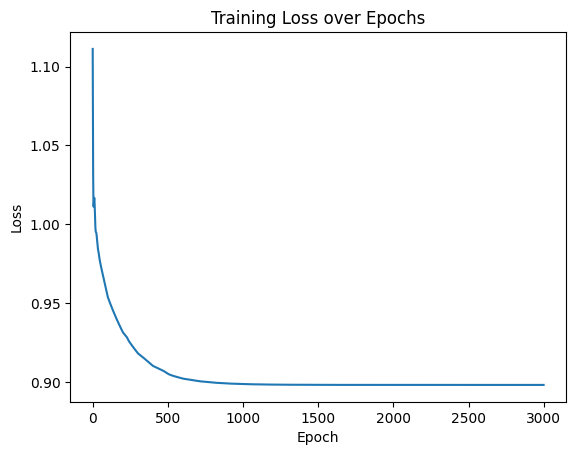

In [365]:
# Graph the loss
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss over Epochs")
plt.show()

In [366]:
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, Y_test)

print(f"\nTest Loss: {test_loss.item():.4f}")



Test Loss: 0.9264


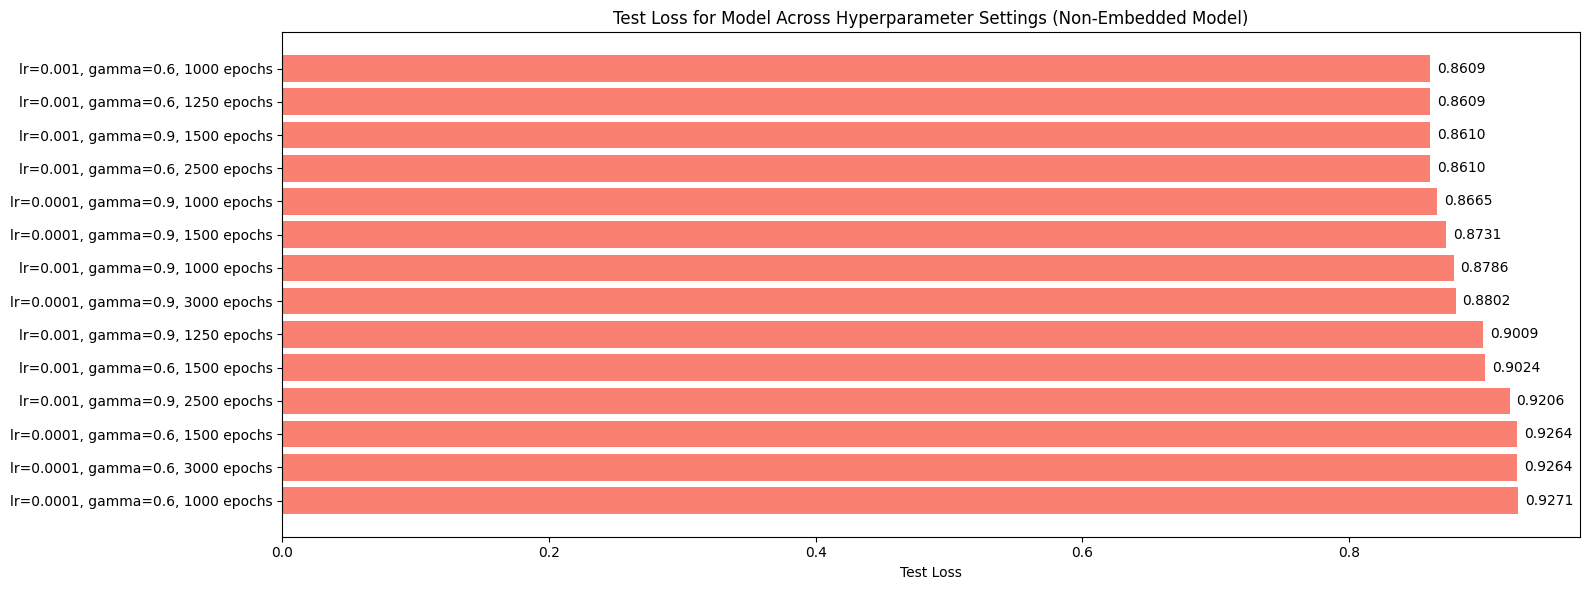

In [367]:
# Dictionary of results for non-embedded model
test_results_non_emb = {
    "lr=0.001, gamma=0.6, 1000 epochs": 0.8609,
    "lr=0.001, gamma=0.9, 1000 epochs": 0.8786,
    "lr=0.001, gamma=0.6, 1500 epochs": 0.9024,
    "lr=0.001, gamma=0.9, 1500 epochs": 0.8610,
    "lr=0.001, gamma=0.6, 1250 epochs": 0.8609,
    "lr=0.001, gamma=0.9, 1250 epochs": 0.9009,
    "lr=0.001, gamma=0.6, 2500 epochs": 0.8610,
    "lr=0.001, gamma=0.9, 2500 epochs": 0.9206,
    "lr=0.0001, gamma=0.6, 1000 epochs": 0.9271,
    "lr=0.0001, gamma=0.9, 1000 epochs": 0.8665,
    "lr=0.0001, gamma=0.6, 1500 epochs": 0.9264,
    "lr=0.0001, gamma=0.9, 1500 epochs": 0.8731,
    "lr=0.0001, gamma=0.9, 3000 epochs": 0.8802,
    "lr=0.0001, gamma=0.6, 3000 epochs": 0.9264
}

# Sort for clarity
sorted_results = dict(sorted(test_results_non_emb.items(), key=lambda x: x[1]))

# Plot
plt.figure(figsize=(16, 6))
bars = plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='salmon')
plt.xlabel("Test Loss")
plt.title("Test Loss for Model Across Hyperparameter Settings (Non-Embedded Model)")
plt.gca().invert_yaxis()
plt.tight_layout()

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.4f}", va='center')

plt.show()

> Based on the experiments, the optimal hyperparameters for this model appear to be:
>
> * Learning Rate: `0.001`
> * Epochs: `1000`
> * Gamma (Decay Factor): `0.60`
> * Step Size (for LR Scheduler): `100`

This configuration yielded the best test loss performance during training.


In [368]:
embedded_model = EmbeddedModel(player_vocab_size, club_vocab_size)

In [369]:
embd_criterion = nn.SmoothL1Loss()
embd_optimizer = optim.Adam(embedded_model.parameters(), lr=0.0001)
embd_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.60)

In [370]:
epochs = 1600
losses_embedded = []

for epoch in range(epochs):
    embedded_model.train()

    # Forward pass (include ID tensors!)
    y_pred = embedded_model(X_train, player_train_ids, club_train_ids)

    loss = embd_criterion(y_pred, Y_train)
    losses_embedded.append(loss.item())

    if (epoch % 10 == 0) | (epoch == epochs - 1):
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    embd_optimizer.zero_grad()
    loss.backward()
    embd_optimizer.step()
    embd_scheduler.step()


Epoch 0 | Loss: 1.1220
Epoch 10 | Loss: 1.0441
Epoch 20 | Loss: 1.0117
Epoch 30 | Loss: 0.9950
Epoch 40 | Loss: 0.9835
Epoch 50 | Loss: 0.9742
Epoch 60 | Loss: 0.9673
Epoch 70 | Loss: 0.9618
Epoch 80 | Loss: 0.9571
Epoch 90 | Loss: 0.9530
Epoch 100 | Loss: 0.9491
Epoch 110 | Loss: 0.9454
Epoch 120 | Loss: 0.9418
Epoch 130 | Loss: 0.9381
Epoch 140 | Loss: 0.9346
Epoch 150 | Loss: 0.9310
Epoch 160 | Loss: 0.9275
Epoch 170 | Loss: 0.9239
Epoch 180 | Loss: 0.9204
Epoch 190 | Loss: 0.9163
Epoch 200 | Loss: 0.9120
Epoch 210 | Loss: 0.9083
Epoch 220 | Loss: 0.9047
Epoch 230 | Loss: 0.9012
Epoch 240 | Loss: 0.8976
Epoch 250 | Loss: 0.8941
Epoch 260 | Loss: 0.8906
Epoch 270 | Loss: 0.8869
Epoch 280 | Loss: 0.8833
Epoch 290 | Loss: 0.8796
Epoch 300 | Loss: 0.8760
Epoch 310 | Loss: 0.8724
Epoch 320 | Loss: 0.8685
Epoch 330 | Loss: 0.8645
Epoch 340 | Loss: 0.8606
Epoch 350 | Loss: 0.8566
Epoch 360 | Loss: 0.8529
Epoch 370 | Loss: 0.8491
Epoch 380 | Loss: 0.8452
Epoch 390 | Loss: 0.8413
Epoch 400 |

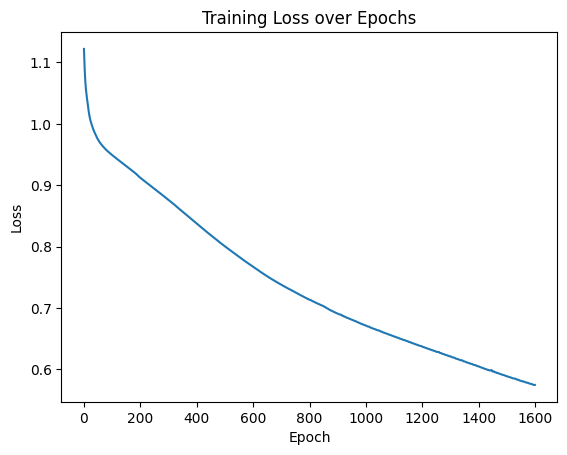

In [371]:
# Graph the loss
plt.plot(range(epochs), losses_embedded)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss over Epochs")
plt.show()

In [372]:
embedded_model.eval()
with torch.no_grad():
    y_test_pred = embedded_model(X_test, player_test_ids, club_test_ids)
    test_loss = criterion(y_test_pred, Y_test)

print(f"\nTest Loss (Embedded Model): {test_loss.item():.4f}")


Test Loss (Embedded Model): 0.9035


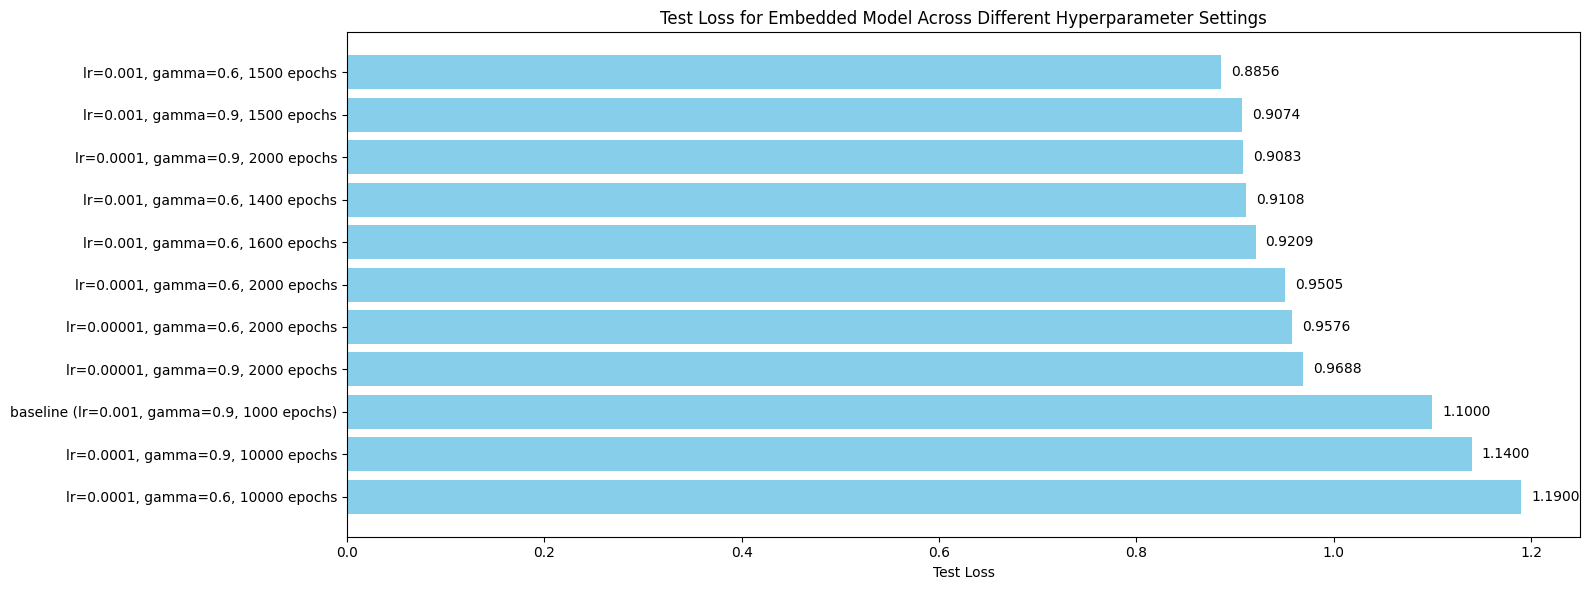

In [373]:
# Dictionary of results
test_results = {
    "lr=0.001, gamma=0.6, 1500 epochs": 0.8856,
    "lr=0.001, gamma=0.6, 1400 epochs": 0.9108,
    "lr=0.001, gamma=0.6, 1600 epochs": 0.9209,
    "lr=0.001, gamma=0.9, 1500 epochs": 0.9074,
    "lr=0.0001, gamma=0.6, 10000 epochs": 1.19,
    "lr=0.0001, gamma=0.9, 10000 epochs": 1.14,
    "lr=0.0001, gamma=0.6, 2000 epochs": 0.9505,
    "lr=0.0001, gamma=0.9, 2000 epochs": 0.9083,
    "lr=0.00001, gamma=0.9, 2000 epochs": 0.9688,
    "lr=0.00001, gamma=0.6, 2000 epochs": 0.9576,
    "baseline (lr=0.001, gamma=0.9, 1000 epochs)": 1.10
}

# Sort the dictionary
sorted_results = dict(sorted(test_results.items(), key=lambda item: item[1]))

# Plot
plt.figure(figsize=(16, 6))
bars = plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='skyblue')
plt.xlabel("Test Loss")
plt.title("Test Loss for Embedded Model Across Different Hyperparameter Settings")
plt.gca().invert_yaxis()
plt.tight_layout()

# Annotate each bar with its value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.4f}", va='center')

plt.show()

> Based on the experiments, the optimal hyperparameters for the embedded model appear to be:
>
> * Learning Rate: `0.001`
> * Epochs: `1500`
> * Gamma (Decay Factor): `0.60`
> * Step Size (for LR Scheduler): `100`

This configuration yielded the best test loss performance during training.


---

### 🔍 Final Evaluation & Model Comparison

After training and tuning both a standard neural network and an embedded model, the results showed that the **non-embedded model** achieved slightly better generalization on the test set:

```
Best Test Loss (Non-Embedded): 0.8609
Best Test Loss (Embedded):     0.8864
```

The most effective configuration for the non-embedded model was:

* learning rate: 0.001
* epochs: 1000
* gamma (learning rate decay): 0.60
* step size: 100

Although the embedded model reached lower training loss, it did not generalize as well. This suggests it may have overfit the training data, potentially learning player- or club-specific patterns that didn’t transfer well to newer FIFA versions.

#### 💡 Key Takeaways

* Simpler models can sometimes generalize better than complex ones, especially on limited data.
* Embedding categorical features can be powerful, but they require thoughtful design and sufficient data to be effective.
* Hyperparameter tuning plays a crucial role in balancing learning efficiency and generalization.
* Model performance should always be evaluated in the context of how the data is split — simulating real-world scenarios (e.g., predicting future seasons) leads to more meaningful evaluation.

---
